In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 10.3 MB/s 
     |████████████████████████████████| 190 kB 8.0 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7187, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 7187 (delta 50), reused 161 (delta 37), pack-reused 6995
Receiving objects: 100% (7187/7187), 13.87 MiB | 28.17 MiB/s, done.
Resolving deltas: 100% (5222/5222), done.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-27 01:39:33--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  9.50MB/s    in 31s     

2022-05-27 01:40:05 (10.1 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1,100),cutout_ratio=[(0.25,0.75)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-27 01:40:09,517 - mmseg - INFO - Loaded 537 images
2022-05-27 01:40:22,358 - mmseg - INFO - Loaded 113 images
2022-05-27 01:40:22,363 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-27 01:40:22,950 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-27 01:40:22,958 - mmseg - INFO - Start running, host: root@9b3d69050ee9, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout
2022-05-27 01:40:22,960 - mmseg - INFO - Hooks will be executed in the foll

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 471s, ETA:     0s

2022-05-27 01:58:13,474 - mmseg - INFO - per class results:
2022-05-27 01:58:13,477 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.66 | 93.17 |
|  building  |  69.4 |  83.7 |
|  Boundary  | 39.74 | 52.33 |
+------------+-------+-------+
2022-05-27 01:58:13,479 - mmseg - INFO - Summary:
2022-05-27 01:58:13,481 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 85.16 | 64.93 | 76.4 |
+-------+-------+------+
2022-05-27 01:58:13,484 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8516, mIoU: 0.6493, mAcc: 0.7640, IoU.background: 0.8566, IoU.building: 0.6940, IoU.Boundary: 0.3974, Acc.background: 0.9317, Acc.building: 0.8370, Acc.Boundary: 0.5233
2022-05-27 01:58:56,286 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 5:18:47, time: 5.138, data_time: 4.738, memory: 3323, decode.loss_dice: 0.3255, decode.loss_focal: 0.0610, decode.loss_lovasz: 0.4980, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 02:12:25,963 - mmseg - INFO - per class results:
2022-05-27 02:12:25,965 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.83 | 93.46 |
|  building  | 73.93 | 86.62 |
|  Boundary  | 45.41 | 60.58 |
+------------+-------+-------+
2022-05-27 02:12:25,967 - mmseg - INFO - Summary:
2022-05-27 02:12:25,969 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 87.2 | 69.06 | 80.22 |
+------+-------+-------+
2022-05-27 02:12:25,971 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8720, mIoU: 0.6906, mAcc: 0.8022, IoU.background: 0.8783, IoU.building: 0.7393, IoU.Boundary: 0.4541, Acc.background: 0.9346, Acc.building: 0.8662, Acc.Boundary: 0.6058
2022-05-27 02:13:06,619 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:38:57, time: 4.738, data_time: 4.338, memory: 3323, decode.loss_dice: 0.3426, decode.loss_focal: 0.0612, decode.loss_lovasz: 0.5112, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 435s, ETA:     0s

2022-05-27 02:26:36,836 - mmseg - INFO - per class results:
2022-05-27 02:26:36,838 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.39 | 94.04 |
|  building  | 74.56 | 86.36 |
|  Boundary  | 47.56 | 62.62 |
+------------+-------+-------+
2022-05-27 02:26:36,840 - mmseg - INFO - Summary:
2022-05-27 02:26:36,842 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.78 | 70.17 | 81.01 |
+-------+-------+-------+
2022-05-27 02:26:36,844 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8778, mIoU: 0.7017, mAcc: 0.8101, IoU.background: 0.8839, IoU.building: 0.7456, IoU.Boundary: 0.4756, Acc.background: 0.9404, Acc.building: 0.8636, Acc.Boundary: 0.6262
2022-05-27 02:27:17,456 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 4:15:43, time: 4.754, data_time: 4.355, memory: 3323, decode.loss_dice: 0.2958, decode.loss_focal: 0.0546, decode.loss_lovasz: 0.4637, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 02:40:46,689 - mmseg - INFO - per class results:
2022-05-27 02:40:46,691 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.34 | 92.13 |
|  building  | 75.19 | 85.96 |
|  Boundary  | 49.71 | 71.49 |
+------------+-------+-------+
2022-05-27 02:40:46,693 - mmseg - INFO - Summary:
2022-05-27 02:40:46,695 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.74 | 71.08 | 83.19 |
+-------+-------+-------+
2022-05-27 02:40:46,698 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8774, mIoU: 0.7108, mAcc: 0.8319, IoU.background: 0.8834, IoU.building: 0.7519, IoU.Boundary: 0.4971, Acc.background: 0.9213, Acc.building: 0.8596, Acc.Boundary: 0.7149
2022-05-27 02:41:27,256 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:56:49, time: 4.737, data_time: 4.338, memory: 3323, decode.loss_dice: 0.2913, decode.loss_focal: 0.0536, decode.loss_lovasz: 0.4608, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 434s, ETA:     0s

2022-05-27 02:54:57,295 - mmseg - INFO - per class results:
2022-05-27 02:54:57,298 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  86.4 | 88.88 |
|  building  | 74.48 | 88.95 |
|  Boundary  | 49.33 | 73.29 |
+------------+-------+-------+
2022-05-27 02:54:57,299 - mmseg - INFO - Summary:
2022-05-27 02:54:57,301 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.72 | 70.07 | 83.71 |
+-------+-------+-------+
2022-05-27 02:54:57,303 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8672, mIoU: 0.7007, mAcc: 0.8371, IoU.background: 0.8640, IoU.building: 0.7448, IoU.Boundary: 0.4933, Acc.background: 0.8888, Acc.building: 0.8895, Acc.Boundary: 0.7329
2022-05-27 02:55:39,221 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:39:54, time: 4.762, data_time: 4.350, memory: 3323, decode.loss_dice: 0.2866, decode.loss_focal: 0.0536, decode.loss_lovasz: 0.4493, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 03:09:09,438 - mmseg - INFO - per class results:
2022-05-27 03:09:09,441 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.71 | 92.68 |
|  building  | 75.96 | 85.07 |
|  Boundary  | 51.71 | 74.17 |
+------------+-------+-------+
2022-05-27 03:09:09,442 - mmseg - INFO - Summary:
2022-05-27 03:09:09,444 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.24 | 72.13 | 83.98 |
+-------+-------+-------+
2022-05-27 03:09:09,448 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8824, mIoU: 0.7213, mAcc: 0.8398, IoU.background: 0.8871, IoU.building: 0.7596, IoU.Boundary: 0.5171, Acc.background: 0.9268, Acc.building: 0.8507, Acc.Boundary: 0.7417
2022-05-27 03:09:50,137 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:23:49, time: 4.737, data_time: 4.337, memory: 3323, decode.loss_dice: 0.3016, decode.loss_focal: 0.0542, decode.loss_lovasz: 0.4693, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 03:23:19,200 - mmseg - INFO - per class results:
2022-05-27 03:23:19,202 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  88.5 | 92.25 |
|  building  | 76.68 | 88.01 |
|  Boundary  | 50.43 | 70.63 |
+------------+-------+-------+
2022-05-27 03:23:19,204 - mmseg - INFO - Summary:
2022-05-27 03:23:19,206 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.19 | 71.87 | 83.63 |
+-------+-------+-------+
2022-05-27 03:23:19,208 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8819, mIoU: 0.7187, mAcc: 0.8363, IoU.background: 0.8850, IoU.building: 0.7668, IoU.Boundary: 0.5043, Acc.background: 0.9225, Acc.building: 0.8801, Acc.Boundary: 0.7063
2022-05-27 03:23:59,297 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 3:08:14, time: 4.729, data_time: 4.335, memory: 3323, decode.loss_dice: 0.2681, decode.loss_focal: 0.0513, decode.loss_lovasz: 0.4371, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 03:37:20,957 - mmseg - INFO - per class results:
2022-05-27 03:37:20,959 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.31 | 93.19 |
|  building  | 76.53 | 86.05 |
|  Boundary  | 51.69 | 72.75 |
+------------+-------+-------+
2022-05-27 03:37:20,961 - mmseg - INFO - Summary:
2022-05-27 03:37:20,964 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 88.6 | 72.51 | 84.0 |
+------+-------+------+
2022-05-27 03:37:20,966 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8860, mIoU: 0.7251, mAcc: 0.8400, IoU.background: 0.8931, IoU.building: 0.7653, IoU.Boundary: 0.5169, Acc.background: 0.9319, Acc.building: 0.8605, Acc.Boundary: 0.7275
2022-05-27 03:38:03,072 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:52:52, time: 4.748, data_time: 4.354, memory: 3323, decode.loss_dice: 0.2859, decode.loss_focal: 0.0499, decode.loss_lovasz: 0.4499, decode.acc_seg: 76.25

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 03:51:23,910 - mmseg - INFO - per class results:
2022-05-27 03:51:23,912 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.46 | 93.47 |
|  building  |  77.4 | 88.36 |
|  Boundary  | 51.39 | 69.48 |
+------------+-------+-------+
2022-05-27 03:51:23,914 - mmseg - INFO - Summary:
2022-05-27 03:51:23,916 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.87 | 72.75 | 83.77 |
+-------+-------+-------+
2022-05-27 03:51:23,919 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8887, mIoU: 0.7275, mAcc: 0.8377, IoU.background: 0.8946, IoU.building: 0.7740, IoU.Boundary: 0.5139, Acc.background: 0.9347, Acc.building: 0.8836, Acc.Boundary: 0.6948
2022-05-27 03:52:03,804 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:37:43, time: 4.726, data_time: 4.334, memory: 3323, decode.loss_dice: 0.2517, decode.loss_focal: 0.0474, decode.loss_lovasz: 0.4119, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 436s, ETA:     0s

2022-05-27 04:05:28,430 - mmseg - INFO - per class results:
2022-05-27 04:05:28,432 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.08 | 92.88 |
|  building  | 77.27 | 88.23 |
|  Boundary  | 51.76 | 71.09 |
+------------+-------+-------+
2022-05-27 04:05:28,434 - mmseg - INFO - Summary:
2022-05-27 04:05:28,436 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 88.7 | 72.7 | 84.06 |
+------+------+-------+
2022-05-27 04:05:28,438 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8870, mIoU: 0.7270, mAcc: 0.8406, IoU.background: 0.8908, IoU.building: 0.7727, IoU.Boundary: 0.5176, Acc.background: 0.9288, Acc.building: 0.8823, Acc.Boundary: 0.7109
2022-05-27 04:06:08,443 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:22:52, time: 4.758, data_time: 4.365, memory: 3323, decode.loss_dice: 0.2581, decode.loss_focal: 0.0478, decode.loss_lovasz: 0.4224, decode.acc_seg: 77.3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 04:19:30,217 - mmseg - INFO - per class results:
2022-05-27 04:19:30,219 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.73 |  95.0 |
|  building  | 76.49 | 85.21 |
|  Boundary  | 51.83 | 68.98 |
+------------+-------+-------+
2022-05-27 04:19:30,221 - mmseg - INFO - Summary:
2022-05-27 04:19:30,223 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.98 | 72.69 | 83.06 |
+-------+-------+-------+
2022-05-27 04:19:30,226 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8898, mIoU: 0.7269, mAcc: 0.8306, IoU.background: 0.8973, IoU.building: 0.7649, IoU.Boundary: 0.5183, Acc.background: 0.9500, Acc.building: 0.8521, Acc.Boundary: 0.6898
2022-05-27 04:20:10,205 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:08:06, time: 4.726, data_time: 4.333, memory: 3323, decode.loss_dice: 0.2670, decode.loss_focal: 0.0494, decode.loss_lovasz: 0.4248, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 04:33:30,933 - mmseg - INFO - per class results:
2022-05-27 04:33:30,935 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.75 | 91.92 |
|  building  | 77.47 |  91.1 |
|  Boundary  | 49.03 | 67.37 |
+------------+-------+-------+
2022-05-27 04:33:30,937 - mmseg - INFO - Summary:
2022-05-27 04:33:30,939 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.29 | 71.75 | 83.46 |
+-------+-------+-------+
2022-05-27 04:33:30,941 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8829, mIoU: 0.7175, mAcc: 0.8346, IoU.background: 0.8875, IoU.building: 0.7747, IoU.Boundary: 0.4903, Acc.background: 0.9192, Acc.building: 0.9110, Acc.Boundary: 0.6737
2022-05-27 04:34:10,843 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:53:28, time: 4.724, data_time: 4.332, memory: 3323, decode.loss_dice: 0.2631, decode.loss_focal: 0.0488, decode.loss_lovasz: 0.4208, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-27 04:47:34,023 - mmseg - INFO - per class results:
2022-05-27 04:47:34,027 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  88.8 | 91.54 |
|  building  | 77.96 | 90.64 |
|  Boundary  | 50.84 | 71.36 |
+------------+-------+-------+
2022-05-27 04:47:34,028 - mmseg - INFO - Summary:
2022-05-27 04:47:34,032 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 88.5 | 72.54 | 84.52 |
+------+-------+-------+
2022-05-27 04:47:34,034 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8850, mIoU: 0.7254, mAcc: 0.8452, IoU.background: 0.8880, IoU.building: 0.7796, IoU.Boundary: 0.5084, Acc.background: 0.9154, Acc.building: 0.9064, Acc.Boundary: 0.7136
2022-05-27 04:48:14,198 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:38:56, time: 4.729, data_time: 4.333, memory: 3323, decode.loss_dice: 0.2654, decode.loss_focal: 0.0463, decode.loss_lovasz: 0.4211, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 436s, ETA:     0s

2022-05-27 05:01:41,916 - mmseg - INFO - per class results:
2022-05-27 05:01:41,918 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.22 | 94.33 |
|  building  | 78.59 | 88.74 |
|  Boundary  | 52.43 | 69.49 |
+------------+-------+-------+
2022-05-27 05:01:41,920 - mmseg - INFO - Summary:
2022-05-27 05:01:41,922 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.5 | 73.74 | 84.19 |
+------+-------+-------+
2022-05-27 05:01:41,924 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8950, mIoU: 0.7374, mAcc: 0.8419, IoU.background: 0.9022, IoU.building: 0.7859, IoU.Boundary: 0.5243, Acc.background: 0.9433, Acc.building: 0.8874, Acc.Boundary: 0.6949
2022-05-27 05:02:21,945 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:24:30, time: 4.760, data_time: 4.366, memory: 3323, decode.loss_dice: 0.2376, decode.loss_focal: 0.0463, decode.loss_lovasz: 0.3994, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 436s, ETA:     0s

2022-05-27 05:15:42,714 - mmseg - INFO - per class results:
2022-05-27 05:15:42,717 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.62 | 92.92 |
|  building  | 78.27 | 89.77 |
|  Boundary  |  52.1 | 70.99 |
+------------+-------+-------+
2022-05-27 05:15:42,719 - mmseg - INFO - Summary:
2022-05-27 05:15:42,721 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.09 | 73.33 | 84.56 |
+-------+-------+-------+
2022-05-27 05:15:42,726 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8909, mIoU: 0.7333, mAcc: 0.8456, IoU.background: 0.8962, IoU.building: 0.7827, IoU.Boundary: 0.5210, Acc.background: 0.9292, Acc.building: 0.8977, Acc.Boundary: 0.7099
2022-05-27 05:16:24,799 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:10:06, time: 4.778, data_time: 4.384, memory: 3323, decode.loss_dice: 0.2635, decode.loss_focal: 0.0480, decode.loss_lovasz: 0.4254, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 436s, ETA:     0s

2022-05-27 05:29:49,870 - mmseg - INFO - per class results:
2022-05-27 05:29:49,873 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.84 |  93.2 |
|  building  | 78.27 | 87.95 |
|  Boundary  | 53.17 | 73.91 |
+------------+-------+-------+
2022-05-27 05:29:49,874 - mmseg - INFO - Summary:
2022-05-27 05:29:49,876 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.23 | 73.76 | 85.02 |
+-------+-------+-------+
2022-05-27 05:29:49,879 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8923, mIoU: 0.7376, mAcc: 0.8502, IoU.background: 0.8984, IoU.building: 0.7827, IoU.Boundary: 0.5317, Acc.background: 0.9320, Acc.building: 0.8795, Acc.Boundary: 0.7391
2022-05-27 05:30:29,889 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:55:44, time: 4.762, data_time: 4.368, memory: 3323, decode.loss_dice: 0.2381, decode.loss_focal: 0.0451, decode.loss_lovasz: 0.3969, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 437s, ETA:     0s

2022-05-27 05:44:00,827 - mmseg - INFO - per class results:
2022-05-27 05:44:00,829 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.97 | 93.64 |
|  building  | 77.98 | 88.59 |
|  Boundary  |  53.1 | 71.54 |
+------------+-------+-------+
2022-05-27 05:44:00,834 - mmseg - INFO - Summary:
2022-05-27 05:44:00,835 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.32 | 73.68 | 84.59 |
+-------+-------+-------+
2022-05-27 05:44:00,837 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8932, mIoU: 0.7368, mAcc: 0.8459, IoU.background: 0.8997, IoU.building: 0.7798, IoU.Boundary: 0.5310, Acc.background: 0.9364, Acc.building: 0.8859, Acc.Boundary: 0.7154
2022-05-27 05:44:41,060 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:41:25, time: 4.771, data_time: 4.376, memory: 3323, decode.loss_dice: 0.2780, decode.loss_focal: 0.0526, decode.loss_lovasz: 0.4405, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 437s, ETA:     0s

2022-05-27 05:58:11,926 - mmseg - INFO - per class results:
2022-05-27 05:58:11,928 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.36 | 94.18 |
|  building  | 78.91 |  87.7 |
|  Boundary  | 53.69 | 73.04 |
+------------+-------+-------+
2022-05-27 05:58:11,930 - mmseg - INFO - Summary:
2022-05-27 05:58:11,932 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.65 | 74.32 | 84.97 |
+-------+-------+-------+
2022-05-27 05:58:11,936 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8965, mIoU: 0.7432, mAcc: 0.8497, IoU.background: 0.9036, IoU.building: 0.7891, IoU.Boundary: 0.5369, Acc.background: 0.9418, Acc.building: 0.8770, Acc.Boundary: 0.7304
2022-05-27 05:58:52,272 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:27:08, time: 4.773, data_time: 4.376, memory: 3323, decode.loss_dice: 0.2630, decode.loss_focal: 0.0488, decode.loss_lovasz: 0.4264, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 437s, ETA:     0s

2022-05-27 06:12:22,881 - mmseg - INFO - per class results:
2022-05-27 06:12:22,885 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.58 | 94.92 |
|  building  | 78.97 | 88.29 |
|  Boundary  | 53.18 | 69.81 |
+------------+-------+-------+
2022-05-27 06:12:22,886 - mmseg - INFO - Summary:
2022-05-27 06:12:22,888 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.8 | 74.24 | 84.34 |
+------+-------+-------+
2022-05-27 06:12:22,890 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8980, mIoU: 0.7424, mAcc: 0.8434, IoU.background: 0.9058, IoU.building: 0.7897, IoU.Boundary: 0.5318, Acc.background: 0.9492, Acc.building: 0.8829, Acc.Boundary: 0.6981
2022-05-27 06:13:03,130 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:12:50, time: 4.775, data_time: 4.379, memory: 3323, decode.loss_dice: 0.2599, decode.loss_focal: 0.0494, decode.loss_lovasz: 0.4211, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 437s, ETA:     0s

2022-05-27 06:26:32,953 - mmseg - INFO - per class results:
2022-05-27 06:26:32,955 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.44 | 94.28 |
|  building  | 78.99 | 88.39 |
|  Boundary  | 53.46 | 71.78 |
+------------+-------+-------+
2022-05-27 06:26:32,957 - mmseg - INFO - Summary:
2022-05-27 06:26:32,962 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 89.7 | 74.3 | 84.81 |
+------+------+-------+
2022-05-27 06:26:32,964 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8970, mIoU: 0.7430, mAcc: 0.8481, IoU.background: 0.9044, IoU.building: 0.7899, IoU.Boundary: 0.5346, Acc.background: 0.9428, Acc.building: 0.8839, Acc.Boundary: 0.7178


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


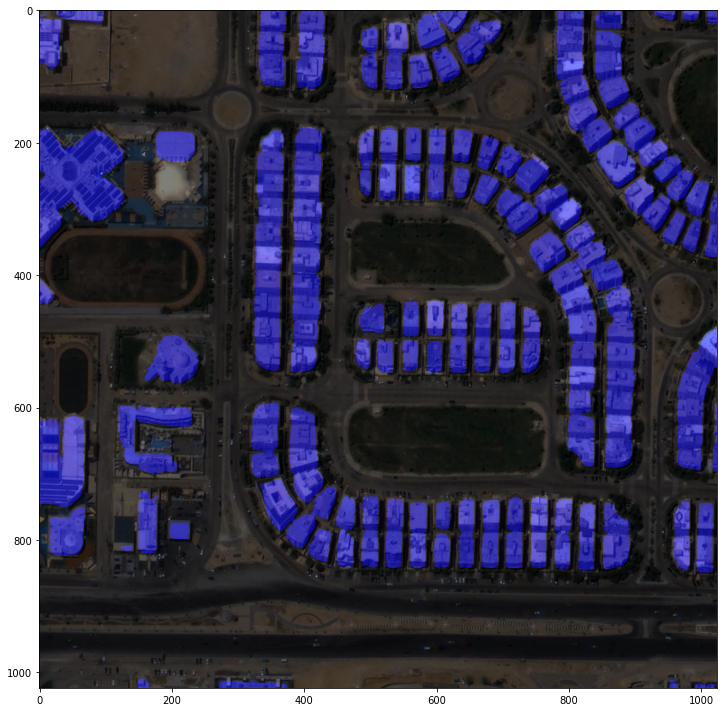

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


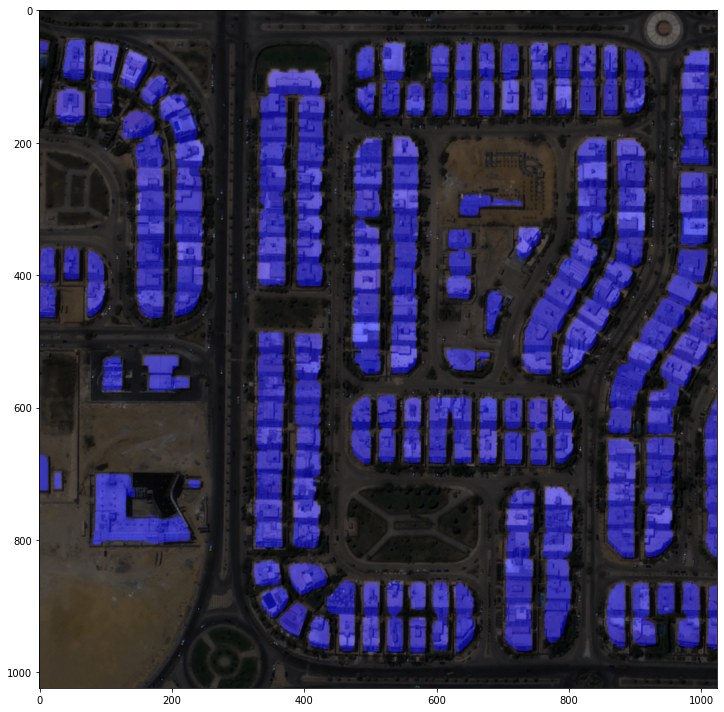

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


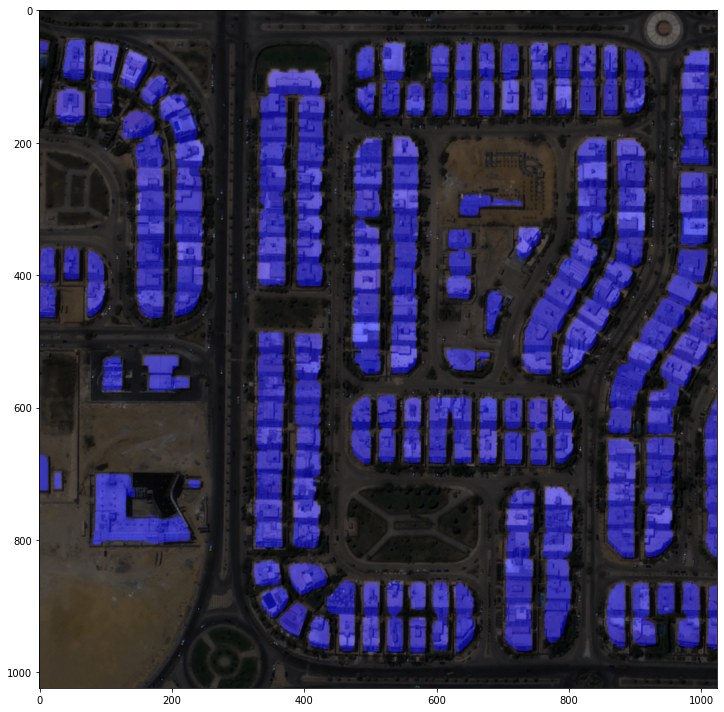

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


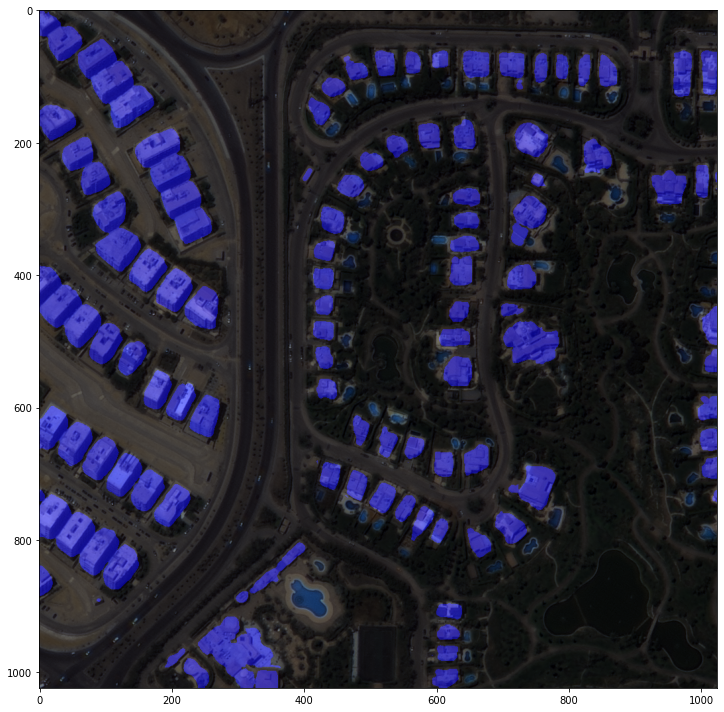

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


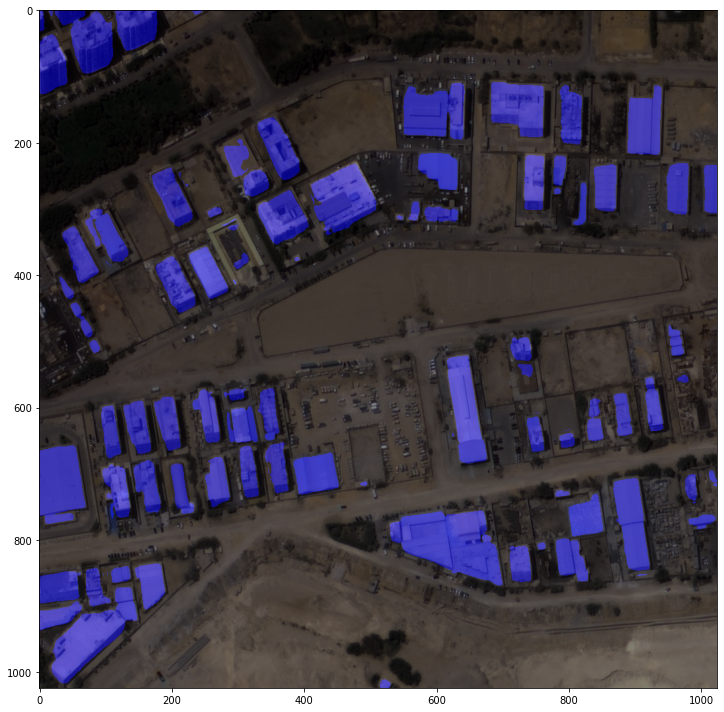

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


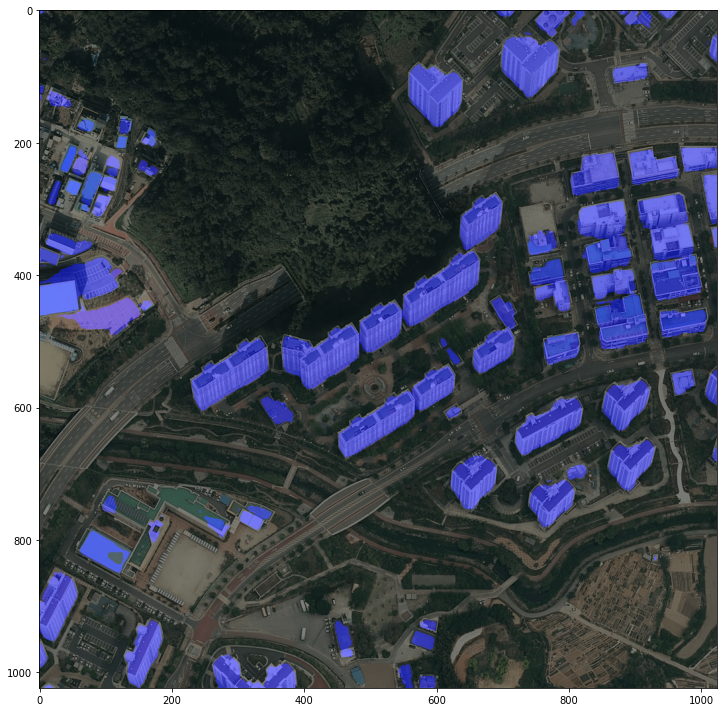

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


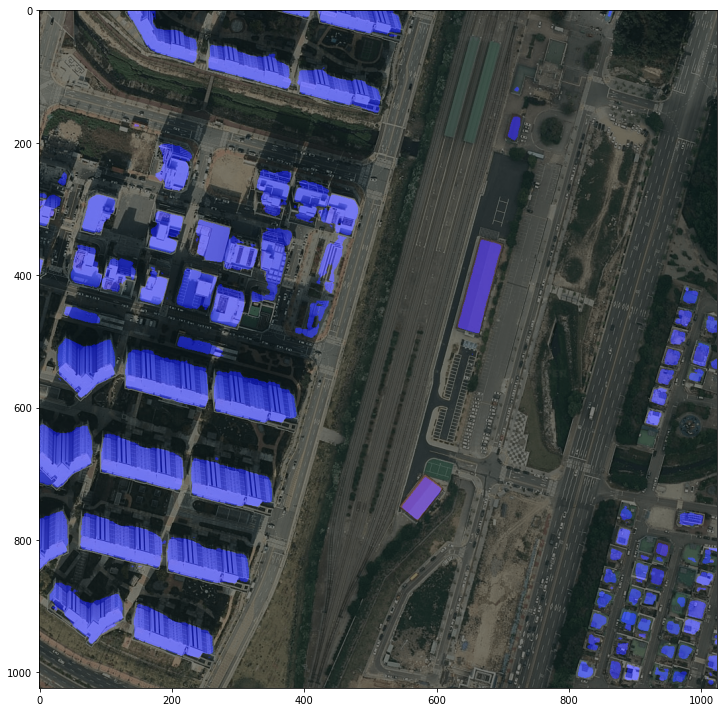

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


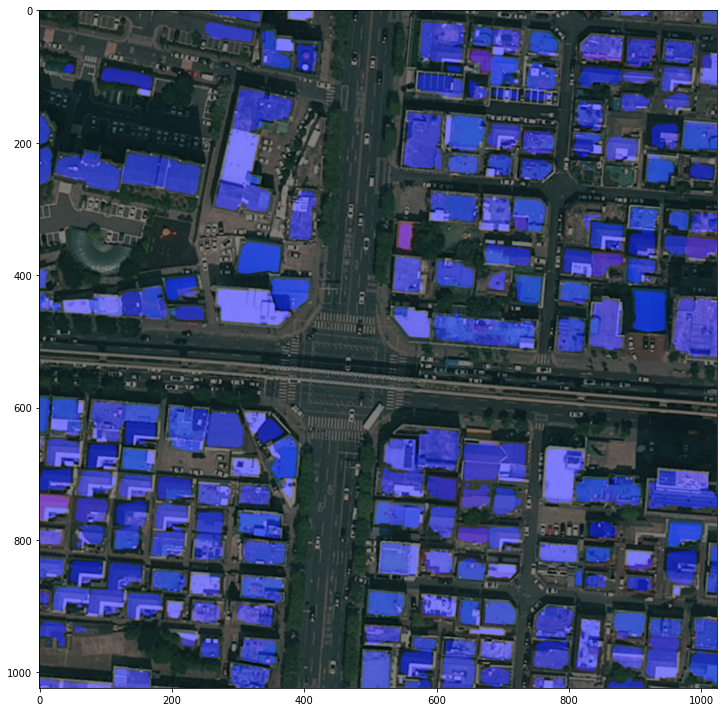

In [24]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)